# Potencia por banda y tarea para todos los sujetos


In [ ]:
import mne
import os 
import sys
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE_DIR = r'C:\Users\adoni\Documents\CurrentStudy'
sys.path.append(rf'{BASE_DIR}\src')

from globals import get_raw_file_path
from preprocessing import preprocess_raw
from raw_loader import load_raw

In [ ]:
to_load = {
    "002": {"stroop":"002", "rest-open":"002", "rest-closed":"002"},
    "003": {"stroop":"002", "rest-open":"002", "rest-closed":"002"},
    "005": {"stroop":"003", "rest-open":"002", "rest-closed":"003"},
    "006": {"stroop":"001", "rest-open":"001", "rest-closed":"001"},
    "008": {"stroop":"002", "rest-open":"003", "rest-closed":"002"},
    "010": {"stroop":"002", "rest-open":"002", "rest-closed":"002"},
    "011": {"stroop":"002", "rest-open":"002", "rest-closed":"002"},
    "012": {"stroop":"002", "rest-open":"002", "rest-closed":"002"},
}

# Definición de bandas clásicas
BANDS = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta':  (12, 30),
    'gamma': (30, 45)
}

colors = {
    'rest-closed': 'royalblue',
    'rest-open': 'seagreen',
    'stroop': 'darkorange'
}
band_order = ['delta', 'theta', 'alpha', 'beta', 'gamma']


## Gráfica para un sujeto

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


C:\Users\adoni\Documents\CurrentStudy\src\preprocessing.py:33: RuntimeWarning: filter_length (8449) is longer than the signal (8068), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=l_freq,
c:\Users\adoni\Documents\CurrentStudy\eeg_env_312\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


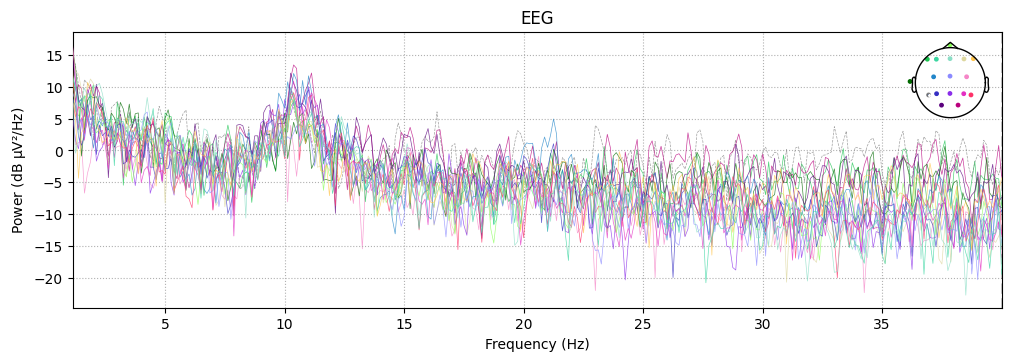

Effective window size : 8.003 (s)
Plotting power spectral density (dB=True).


C:\Users\adoni\Documents\CurrentStudy\src\preprocessing.py:33: RuntimeWarning: filter_length (8445) is longer than the signal (6920), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=l_freq,
c:\Users\adoni\Documents\CurrentStudy\eeg_env_312\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


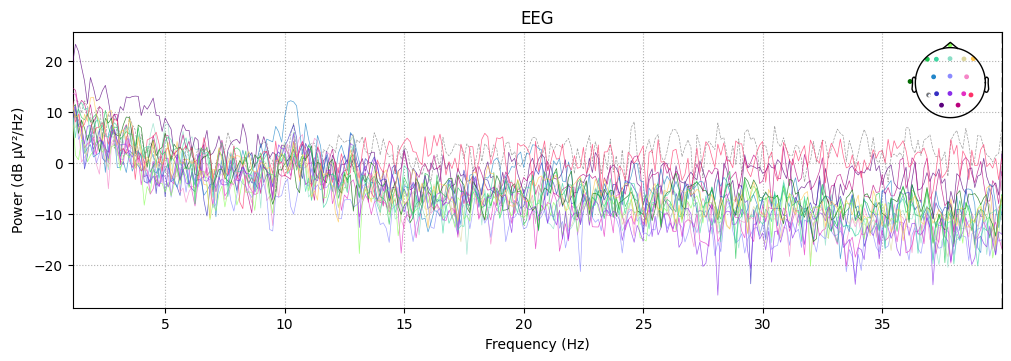

Effective window size : 8.001 (s)
Plotting power spectral density (dB=True).


c:\Users\adoni\Documents\CurrentStudy\eeg_env_312\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


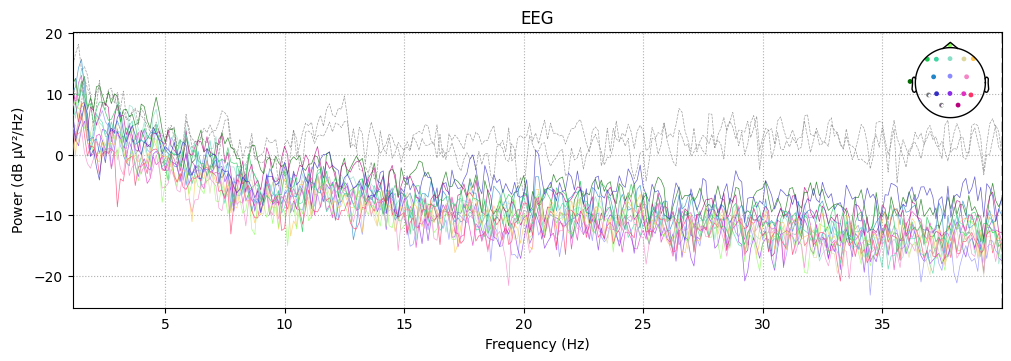

In [82]:
sub = '003'
for task in ['rest-closed', 'rest-open', 'stroop']:
    raw = load_raw(sub, task, to_load[sub][task], 'ica-clean')
    raw = preprocess_raw(raw)
    raw.compute_psd(fmin=1, fmax=40).plot()
    plt.show()

C:\Users\adoni\Documents\CurrentStudy\src\preprocessing.py:33: RuntimeWarning: filter_length (8449) is longer than the signal (8068), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=l_freq,
C:\Users\adoni\Documents\CurrentStudy\src\preprocessing.py:33: RuntimeWarning: filter_length (8445) is longer than the signal (6920), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=l_freq,
C:\Users\adoni\Documents\CurrentStudy\src\preprocessing.py:33: RuntimeWarning: filter_length (8449) is longer than the signal (7944), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=l_freq,
C:\Users\adoni\Documents\CurrentStudy\src\preprocessing.py:33: RuntimeWarning: filter_length (8447) is longer than the signal (7815), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=l_freq,
C:\Users\adoni\Documents\CurrentStudy\src\preprocessing.py:33: RuntimeWa

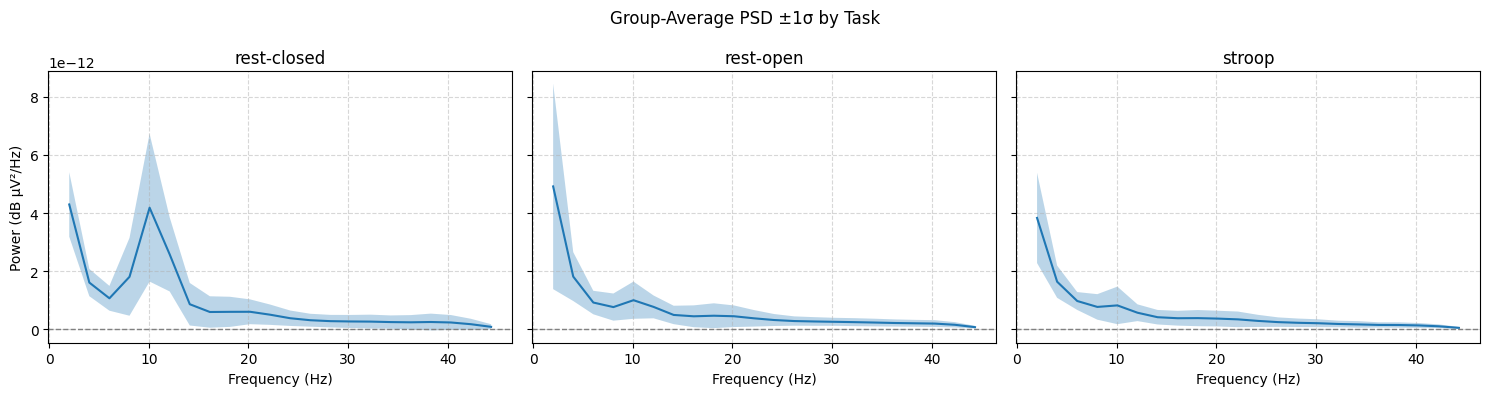

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Asume definidos: to_load, load_raw, preprocess_raw
subjects = list(to_load.keys())
tasks = ['rest-closed', 'rest-open', 'stroop']

# Parámetros de PSD
fmin, fmax = 1, 45
n_fft = 127

# Acumuladores
psd_subjects = {task: [] for task in tasks}
freqs = None

# 1) Calcular PSD por sujeto y tarea
for sub in subjects:
    for task in tasks:
        run = to_load[sub][task]
        raw = load_raw(sub, task, run, 'ica-clean')
        raw = preprocess_raw(raw)
        psd = raw.compute_psd(fmin=fmin, fmax=fmax,
                              n_fft=n_fft, method='welch', verbose=False)
        if freqs is None:
            freqs = psd.freqs
        data = psd.get_data()            # (n_channels, n_freqs)
        psd_subjects[task].append(data.mean(axis=0))

# 2) Media y σ entre sujetos
summary_psd = {}
for task in tasks:
    arr = np.stack(psd_subjects[task], axis=0)
    summary_psd[task] = {
        'mean': arr.mean(axis=0),
        'std':  arr.std(axis=0)
    }

# 3) Plots grupales en 1x3 subplots con eje Y compartido
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for ax, task in zip(axes, tasks):
    m = summary_psd[task]['mean']
    s = summary_psd[task]['std']
    ax.plot(freqs, m)
    ax.fill_between(freqs, m - s, m + s, alpha=0.3)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_title(task)
    ax.set_xlabel("Frequency (Hz)")
    ax.grid(linestyle='--', alpha=0.5)


axes[0].set_ylabel("Power (dB μV²/Hz)")
fig.suptitle("Group-Average PSD ±1σ by Task")
fig.tight_layout()
plt.show()


## Cálculo

En este bloque se calcula la potencia espectral promedio para cada banda de frecuencia clásica (delta, theta, alpha, beta, gamma) en cada combinación de sujeto y tarea experimental. Para ello, se procesan los datos crudos de EEG, se calcula la densidad espectral de potencia (PSD) usando el método de Welch y se obtiene la potencia media en cada banda. Los resultados se almacenan en un DataFrame, que posteriormente se normaliza por sujeto mediante z-score para facilitar la comparación entre sujetos. Finalmente, los datos normalizados y sin normalizar se guardan en archivos CSV y se calculan estadísticas descriptivas (media y desviación estándar) para cada banda y tarea.

In [54]:
records = []
for sub, tasks in to_load.items():
    for task, run in tasks.items():
        raw = load_raw(sub, task, run, 'ica-clean')
        raw = preprocess_raw(raw)
        
        psd = raw.compute_psd(fmin=1, fmax=45,
                              n_fft=2048,
                              method='welch',
                              verbose=False)
        psds = psd.get_data()   # shape (n_channels, n_freqs)
        freqs = psd.freqs
        
        for band, (fmin, fmax) in BANDS.items():
            idx = np.where((freqs >= fmin) & (freqs < fmax))[0]
            power = psds[:, idx].mean()
            records.append({
                'subject': sub,
                'task':     task,
                'band':     band,
                'power':    power
            })

# DataFrame
df = pd.DataFrame(records)

# Normalización por sujeto (z-score)
df['power_norm'] = df.groupby('subject')['power'] \
                     .transform(lambda x: (x - x.mean()) / x.std())

# Guardamos ambas versiones
df.to_csv("band_power_per_subject_task.csv", index=False)
df.to_csv("band_power_per_subject_task_normalized.csv", index=False)

# Estadísticos sobre la señal normalizada
summary = (df
    .groupby(['task','band'])['power_norm']
    .agg(mean='mean', std='std')
    .reset_index()
)

C:\Users\adoni\Documents\CurrentStudy\src\preprocessing.py:33: RuntimeWarning: filter_length (8445) is longer than the signal (6920), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=l_freq,
C:\Users\adoni\Documents\CurrentStudy\src\preprocessing.py:33: RuntimeWarning: filter_length (8449) is longer than the signal (8068), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=l_freq,
C:\Users\adoni\Documents\CurrentStudy\src\preprocessing.py:33: RuntimeWarning: filter_length (8449) is longer than the signal (7944), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=l_freq,
C:\Users\adoni\Documents\CurrentStudy\src\preprocessing.py:33: RuntimeWarning: filter_length (8447) is longer than the signal (7815), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=l_freq,
C:\Users\adoni\Documents\CurrentStudy\src\preprocessing.py:33: RuntimeWa

In [73]:
summary

,task,band,mean,std
0,rest-closed,alpha,1.392797,1.024495
1,rest-closed,beta,-0.557865,0.092580
2,rest-closed,delta,1.513845,0.624052
3,rest-closed,gamma,-0.749319,0.131211
4,rest-closed,theta,-0.171583,0.213238
5,rest-open,alpha,-0.354222,0.275267
6,rest-open,beta,-0.643525,0.055476
7,rest-open,delta,1.442300,0.758774
8,rest-open,gamma,-0.752569,0.146770
9,rest-open,theta,-0.341612,0.113532


## Gráficos comparativos

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

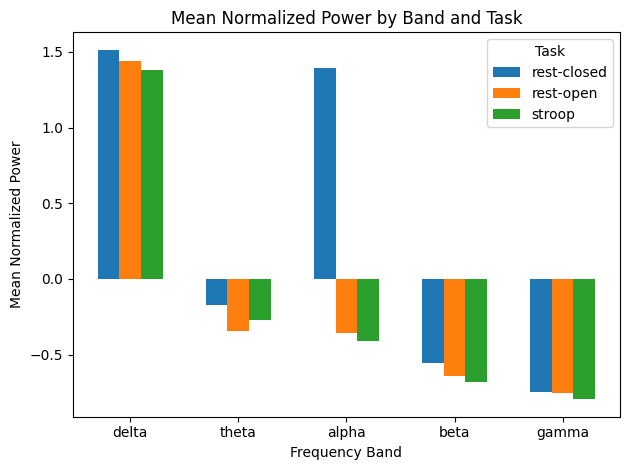

In [95]:
try:
    df
except NameError:
    try:
        df = pd.read_csv("band_power_per_subject_task_normalized.csv")
    except FileNotFoundError:
        print("CSV normalizado no encontrado. Genera primero 'band_power_per_subject_task_normalized.csv'.")
        df = None

if df is not None:
    tasks = sorted(df['task'].unique())
    # Estadísticos normalizados
    summary_norm = df.groupby(['task', 'band'])['power_norm'].agg(['mean', 'std']).reset_index()

    # 2) Gráfico de barras agrupadas de la media normalizada
    bar_width = 0.2
    x = np.arange(len(band_order))
    plt.figure()
    for i, task in enumerate(tasks):
        data = summary_norm[summary_norm['task'] == task].set_index('band').loc[band_order].reset_index()
        plt.bar(x + i * bar_width, data['mean'], width=bar_width, label=task)
    plt.xlabel("Frequency Band")
    plt.ylabel("Mean Normalized Power")
    plt.title("Mean Normalized Power by Band and Task")
    plt.xticks(x + bar_width * (len(tasks) - 1) / 2, band_order)
    plt.legend(title="Task")
    plt.tight_layout()
    plt.show()


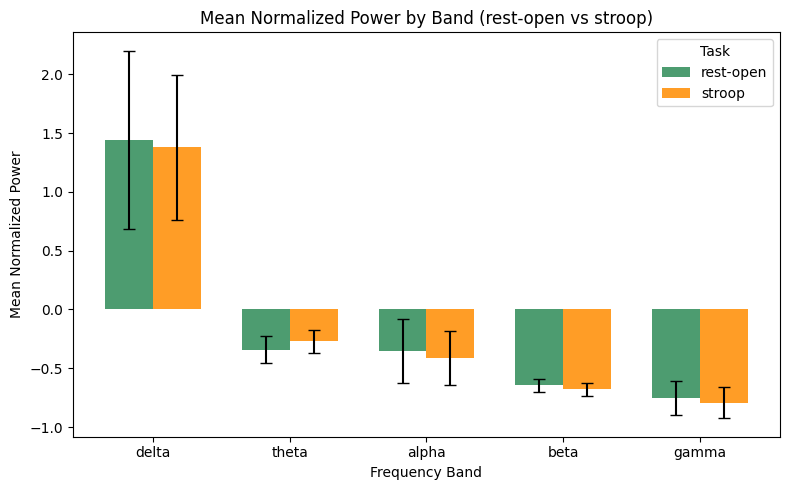

In [96]:

band_order = ['delta', 'theta', 'alpha', 'beta', 'gamma']

try:
    df
except NameError:
    try:
        df = pd.read_csv("band_power_per_subject_task_normalized.csv")
    except FileNotFoundError:
        print("CSV normalizado no encontrado. Genera primero 'band_power_per_subject_task_normalized.csv'.")
        df = None

if df is not None:
    tasks = ['rest-open', 'stroop']  # Solo estas dos tareas
    summary_norm = df.groupby(['task', 'band'])['power_norm'].agg(['mean', 'std']).reset_index()

    bar_width = 0.35
    x = np.arange(len(band_order))
    plt.figure(figsize=(8, 5))
    for i, task in enumerate(tasks):
        data = summary_norm[summary_norm['task'] == task].set_index('band').loc[band_order].reset_index()
        plt.bar(x + i * bar_width, data['mean'], width=bar_width, label=task, color=colors[task], yerr=data['std'], capsize=4, alpha=0.85)
    plt.xlabel("Frequency Band")
    plt.ylabel("Mean Normalized Power")
    plt.title("Mean Normalized Power by Band (rest-open vs stroop)")
    plt.xticks(x + bar_width / 2, band_order)
    plt.legend(title="Task")
    plt.tight_layout()
    plt.show()

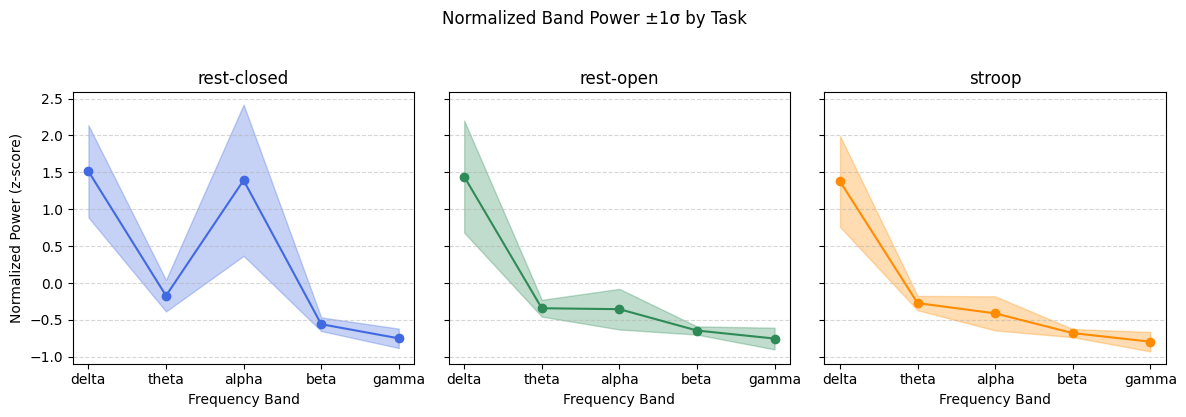

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Carga de datos normalizados
df = pd.read_csv("band_power_per_subject_task_normalized.csv")

tasks = ['rest-closed', 'rest-open', 'stroop']
# 3) Cálculo de estadísticas normalizadas
summary_norm = (
    df.groupby(['task', 'band'])['power_norm']
      .agg(['mean','std'])
      .reset_index()
)

# 4) Crear subplots compartiendo eje Y
fig, axes = plt.subplots(1, len(tasks), figsize=(4 * len(tasks), 4),
                         sharey=True)

for ax, task in zip(axes, tasks):
    data = (
        summary_norm[summary_norm['task'] == task]
        .set_index('band')
        .loc[band_order]
        .reset_index()
    )
    # Línea de medias
    ax.plot(data['band'], data['mean'], marker='o', color=colors[task])
    # Banda de variabilidad
    ax.fill_between(
        data['band'],
        data['mean'] - data['std'],
        data['mean'] + data['std'],
        alpha=0.3,
        color=colors[task]
    )
    # Grid horizontal
    ax.yaxis.grid(True, linestyle='--', alpha=0.5)

    ax.set_title(task)
    ax.set_xlabel("Frequency Band")

# Solo el primer subplot lleva etiqueta Y
axes[0].set_ylabel("Normalized Power (z-score)")

fig.suptitle("Normalized Band Power ±1σ by Task", y=1.03)
fig.tight_layout()
plt.show()
